# Experiment and path specification

In [1]:
# Specify the experiment for analysis
experiment='cxilu9218'
runNumber = 91

# Set the installation and output path
import os
os.environ['INSTALLPATH']= '/cds/home/i/igabalsk/TRXS-Run18'
os.environ['OUTPUTPATH']= '/cds/data/psdm/%s/%s/scratch' % (experiment[0:3],experiment)

# Import Libraries

In [2]:
# Magic iPython command to enable plotting
%matplotlib inline

# Load in the pythonBatchMagic library
import sys
print os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic'
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/pythonBatchMagic')
from pythonBatchMagic import *
# Determine current user
currentUser, error = unixCMD("echo $USER")
print(currentUser)
os.environ['RESULTSPATH']= ('/cds/data/psdm/%s/%s/results/%s' % (experiment[0:3],experiment,currentUser)).strip()
if not os.path.exists(os.environ['RESULTSPATH']):
    os.mkdir(os.environ['RESULTSPATH'])

/cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic
Current user is igabalsk will output batch to /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch
igabalsk



# Leveraging the batch queue to quickly grab detector data

## Loading libraries

In [3]:
sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/LCLS')
from LCLSdefault import *

sys.path.insert(0, os.environ['INSTALLPATH']+'/Libraries/mattsLibraries')
from picklez import *

# Load in the get data library
from dataAnalysis import *

# Load in the batch library for lcls
from lclsBatch import *

/cds/data/psdm/cxi/cxilu9218/scratch/Memories/getCSPADcoords remembered!
Current user is igabalsk will output batch to /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch


## Load point data

In [4]:
# pointData = load_obj( os.environ['RESULTSPATH']+'/pointData-run-%d' % runNumber )
pointData = load_obj('/cds/data/psdm/cxi/cxilu9218/results/mrware/pointData-run-%d' % runNumber)

def dropEmpty(pointData):

    filledBin = (pointData['seconds'] > 0)    

    for key in pointData.keys():
        pointData[key]=pointData[key][filledBin] 
        
    return pointData

def dropNaN(pointData):
    goodBin = np.ones(pointData['seconds'].shape, dtype=bool)
    for key in pointData.keys():
        if not pointData[key].dtype==np.dtype(object) and pointData[key].shape==pointData['seconds'].shape:
            goodBin = goodBin & ~np.isnan(pointData[key])
    for key in pointData.keys():
        pointData[key]=pointData[key][goodBin]
    return pointData
print len(pointData['seconds'])
pointData_masked = dropNaN(dropEmpty(pointData))
print 'Number of good shots: ', len(pointData_masked['seconds'])

/cds/data/psdm/cxi/cxilu9218/results/mrware/pointData-run-91 remembered!
58200
Number of good shots:  58200


## Plot histogram of result

['xpos', 'uvint1', 'xrayOn', 'seconds', 'nanoseconds', 'xint', 'ypos', 'fiducials', 'ttfltpos', 'rois', 'stageencoder', 'vitpos', 'photonHist', 'ebeamcharge', 'uvint', 'xrayEnergy', 'laserOn', 'gasPressure']


/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/reg/g/psdm/sw/conda1/inst/miniconda2-prod-rhel7/envs/ana-2.0.11/lib/python2.7/site-packages/matplotlib/font_manager.py:1333: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


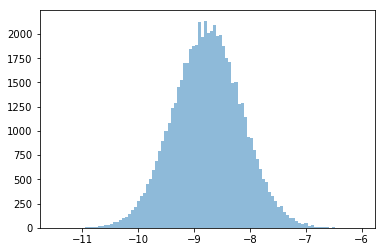

In [5]:
detArrays = pointData
print detArrays.keys()

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(detArrays['uvint1'], bins=100,normed=False, alpha=0.5);

# Read in CSPAD via batch job

## Specify good idxs

In [39]:
goodIdx = runFilter( pointData , filterOn=['ttfltpos','uvint','uvint1'], maddevs=3 ).astype(bool)
gooseIdx = ~pointData['laserOn']
goodIdx = goodIdx & pointData['laserOn'] & pointData['xrayOn']
print 'Number of good shots: ', len(goodIdx[goodIdx==True])
print 'Number of goose shots: ', len(gooseIdx[gooseIdx==True])

Number of good shots:  38753
Number of goose shots:  10246


## Now generate time delays

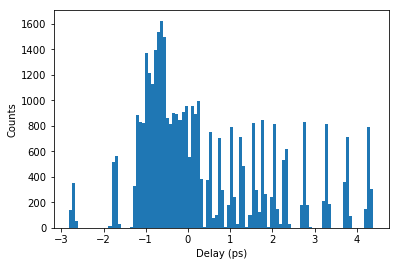

In [40]:
# Calibrated timetool for LU92
TTPoly = np.array([2.95684259e-06, -1.43969413e-03]) 

TTFltPos = pointData['ttfltpos']
TTCorrFltPos = TTPoly[1]*TTFltPos+TTPoly[0]
TTTime = TTCorrFltPos - 1e9/3e8*2*(pointData['stageencoder']-56.35)

# NOTE: This is a placeholder, and should be removed on runs with timetool data
# TTTime = np.zeros(pointData['xrayEnergy'].shape)

fig2, ax2 = plt.subplots(1, 1)
ax2.hist(TTTime[goodIdx], bins=100,normed=False, alpha=1)
ax2.set_xlabel('Delay (ps)')
ax2.set_ylabel('Counts')
plt.show()

# Read in all images
## If you just want to look at all the images at once

In [41]:
# tagList = []
# size_slice = int(len(goodIdx[goodIdx==True])/20)
# print size_slice
# for idx in range(20):
#     filteredSeconds = pointData['seconds'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     filteredNanoseconds = pointData['nanoseconds'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     filteredFiducials = pointData['fiducials'][goodIdx][0+size_slice*idx:size_slice+size_slice*idx]
#     tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# # batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
# batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
# timebins=np.arange(10)
# batchThreads.Queue = 'psanaq'
# batchThreads.RunType = 'mpirun python2'
# batchThreads.start()

In [42]:
print np.unique(TTTime)
print np.unique(pointData['stageencoder'])

[-2.85308659 -2.8230254  -2.821082   ...  4.50000296  4.99666962
  5.00000296]
[55.6    55.6005 55.675  55.6755 55.7505 55.825  55.8255 55.9    55.9005
 55.938  55.9755 56.0125 56.0495 56.05   56.0875 56.125  56.1295 56.1625
 56.2    56.2005 56.215  56.23   56.245  56.26   56.275  56.2755 56.29
 56.305  56.32   56.3275 56.335  56.3355 56.3425 56.35   56.3575 56.358
 56.3725 56.373  56.38   56.395  56.41   56.425  56.5    56.65   56.6505]


# Read in timebinned CSPAD
## If you want to timebin your images

In [47]:
# timebins = np.arange( -1.5,1.5,.03 )
# timebins are in picoseconds
# timebins = np.arange( 2.,5.5,.03 ) 
# timebins = np.arange( -2, 2, .05 )
# timebins = np.array([-1.25,0.75])
# timebins = np.unique(TTTime)
def rebin_stage_positions(stage_positions):
    unique = np.sort(np.unique(stage_positions))
    unique_binned = []
    for i, val in enumerate(unique[:-1]):
        if unique[i+1]-unique[i]>0.004:
            unique_binned.append(unique[i])
    unique_binned.append(unique[-1])
    return np.array(unique_binned)
timebins = 1e9/3e8*2*(rebin_stage_positions(pointData['stageencoder'])-56.35)
print 'Number of timebins: ', len(timebins)
# dt = timebins[1]-timebins[0]
dt = np.min(np.diff(timebins))
print 'dt (ps): ',dt
timebins = np.concatenate((np.array([-100]),timebins))
NT = timebins.size

# print np.around(timebins,3)
# print np.sort(1e9/3e8*2*(rebin_stage_positions(pointData['stageencoder'])-56.35))

tagList = []
for idx, t in enumerate(timebins):
    tIndex = (TTTime >= t-dt/2.)&(TTTime < t+dt/2.)
    allIndex = tIndex & goodIdx
    filteredSeconds = pointData['seconds'][allIndex]
    filteredNanoseconds = pointData['nanoseconds'][allIndex]
    filteredFiducials = pointData['fiducials'][allIndex]
    tagList.append( {'seconds':filteredSeconds, 'nanoseconds':filteredNanoseconds, 'fiducials':filteredFiducials} )

# batchThreads = batchCSPADGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')
batchThreads = batchCSPADMVGrabber (tagList, experiment=experiment, runNumber=runNumber, detType='Jungfrau')

batchThreads.Queue = 'psanaq'
batchThreads.RunType = 'mpirun python2'
batchThreads.start()


Number of timebins:  34
dt (ps):  0.030000000000001137
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-91-temp-CSPAD-0.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPADMV-run-91-temp-CSPAD-0.py; exit'
Output: Job <653743> is submitted to queue <psanaq>.

Error: 
Deleting the old output file ...
Output: 
Error: None
Deleting the old executable file ...
Output: 
Error: None
Submitting: ssh psana 'bsub -n 1 -R "rusage[mem=7000]" -q psanaq -o /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Output/CSPADMV-run-91-temp-CSPAD-1.out /cds/home/i/igabalsk/TRXS-Run18/Libraries/pythonBatchMagic/BatchWrapper.sh mpirun python2 /cds/data/psdm/cxi/cxilu9218/scratch/igabalsk/Batch/Python/CSPAD

Output: Job <653980> is submitted to queue <psanaq>.

Error: 


## Check job status

In [ ]:
print batchThreads.status
stdoutdata, stderrdata = bjobs()
print stdoutdata
print stderrdata

## Kill threads if they die

In [ ]:
batchThreads.requestStop()
time.sleep(5)
stdoutdata, stderrdata = bkill(killAll=True)
print stdoutdata
print stderrdata

# Save resulting CSPAD

In [ ]:
batchThreads.gather()
CSPAD = batchThreads.CSPAD[:,:,:,1:]
variance = batchThreads.variance[:,:,:,1:]
counts = batchThreads.counts[1:]
timebins_goose = timebins[0:1]
CSPAD_goose = batchThreads.CSPAD[:,:,:,0]
variance_goose = batchThreads.variance[:,:,:,0]
counts_goose = batchThreads.counts[0:1]

In [ ]:
from scipy.io import savemat
import h5py

# save as numpy array
np.save(os.environ['RESULTSPATH']+'/timebins-run-%d' % runNumber ,timebins)
np.save(os.environ['RESULTSPATH']+'/CSPAD-run-%d' % runNumber  , CSPAD)
np.save(os.environ['RESULTSPATH']+'/variance-run-%d' %  runNumber , variance)
np.save(os.environ['RESULTSPATH']+'/counts-run-%d' % runNumber  , counts)
np.save(os.environ['RESULTSPATH']+'/timebins_goose-run-%d' % runNumber ,timebins_goose)
np.save(os.environ['RESULTSPATH']+'/CSPAD_goose-run-%d' % runNumber  , CSPAD_goose)
np.save(os.environ['RESULTSPATH']+'/variance_goose-run-%d' %  runNumber , variance_goose)
np.save(os.environ['RESULTSPATH']+'/counts_goose-run-%d' % runNumber  , counts_goose)

# save as .mat
# filename = os.environ['RESULTSPATH']+'/timebinned-detector-images-run-%d' % runNumber
# mdict = {'timebins':timebins,'CSPAD':CSPAD,'variance':variance,'counts':counts}
# savemat(filename, mdict)

# save as .h5
filename = os.environ['RESULTSPATH']+'/timebinned-detector-images-run-%d.h5' % runNumber
with h5py.File(filename, 'w') as hf:
    hf.create_dataset("timebins",  data=timebins)
    hf.create_dataset("CSPAD",  data=CSPAD)
    hf.create_dataset("variance",  data=variance)
    hf.create_dataset("counts",  data=counts)
    hf.create_dataset("timebins_goose",  data=timebins_goose)
    hf.create_dataset("CSPAD_goose",  data=CSPAD_goose)
    hf.create_dataset("variance_goose",  data=variance_goose)
    hf.create_dataset("counts_goose",  data=counts_goose)

# Plot CSPAD

In [ ]:
# # Optional code if timebinned frames are already saved
timebins = np.load(os.environ['RESULTSPATH']+'/timebins-run-%d.npy' % runNumber )
CSPAD = np.load(os.environ['RESULTSPATH']+'/CSPAD-run-%d.npy' % runNumber)
variance = np.load(os.environ['RESULTSPATH']+'/variance-run-%d.npy' % runNumber)
counts = np.load(os.environ['RESULTSPATH']+'/counts-run-%d.npy' % runNumber)
timebins_goose = np.load(os.environ['RESULTSPATH']+'/timebins_goose-run-%d.npy' % runNumber )
CSPAD_goose = np.load(os.environ['RESULTSPATH']+'/CSPAD_goose-run-%d.npy' % runNumber)
variance_goose = np.load(os.environ['RESULTSPATH']+'/variance_goose-run-%d.npy' % runNumber)
counts_goose = np.load(os.environ['RESULTSPATH']+'/counts_goose-run-%d.npy' % runNumber)

In [ ]:
for i in range(CSPAD.shape[-1]):
    m = np.mean(CSPAD[:,:,:,i])
    if not np.isnan(m):
        print i, np.mean(CSPAD[:,:,:,i]), counts[i][0], timebins[i]

In [ ]:
from IPython.display import clear_output
from plotStyles import *

def plotCSPAD( cspad , x , y, cspadMask=None, zLims = None, divergent=False, NTILE=8 ):
    figOpts = {'xLims':[-1e5,1e5],'yLims':[-1e5,1e5],'divergent':divergent, 'xIn':3, 'yIn':3*11.5/14.5}
    
    if zLims is not None:
        figOpts['zLims'] = zLims
    
    for iTile in range(NTILE):
    
        if cspadMask is not None:
            cspadTile = cspad[iTile,:,:]
            tileMask = ~cspadMask[iTile,:,:]
            cspadTile[tileMask] = 0
        
        if iTile == 0:
            newFigure = True
        else:
            newFigure = False
            
        clear_output()
        colorPlot( x[iTile,:,:], y[iTile,:,:], cspadTile , newFigure=newFigure, **figOpts);


x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)

filename = os.environ['RESULTSPATH']+'/detector-geometry
mdict = {'x':x,'y':y}
savemat(filename, mdict)
# cspadMask = createMask(experiment=experiment, run=runNumber, detType='Jungfrau').astype(bool)
cspadMask = np.ones_like(x).astype(bool)
print(cspadMask.shape)

print CSPAD.shape
CSPADbinned = CSPAD

# CSPADbinned[CSPADbinned>10]=0
CSPAD2plot = np.nansum(CSPADbinned[:,:,:,:],axis=-1)#-CSPADbinned[:,:,:,53]
plotCSPAD( 100*CSPAD2plot, x , y , zLims=[0,5],
          cspadMask=cspadMask, divergent=False, NTILE=8 )
# plt.savefig('background_thresholded_summed_image.png')

In [ ]:
print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format('Index','Count','Sum','Median','Variance')
for i in range(CSPAD.shape[-1]):
    if counts[i][0]>0:
        vals = (i, counts[i][0], round(np.sum(CSPAD[:,:,:,i])),round(np.median(CSPAD[:,:,:,i]),4), round(np.var(CSPAD[:,:,:,i]),4))
        print '{0:<5} {1:>5} {2:>8} {3:>8} {4:>8}'.format(*vals)

In [ ]:
x,y = CSPADgeometry(detType='Jungfrau', run=runNumber, experiment=experiment)

filename = os.environ['RESULTSPATH']+'/detector-geometry'
mdict = {'x':x,'y':y}
savemat(filename, mdict)